In [225]:
# !pip install numpy pandas xarray xskillscore
# !pip install cdsapi
# !pip install matplotlib cartopy
# !pip install cfgrib

# **1.LOAD THE REQUIRED LIBRARIES**

In [226]:
# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import xarray as xr
import pandas as pd
import numpy as np

# Forecast verification metrics with xarray
import xskillscore as xs

# Date and calendar libraries
from dateutil.relativedelta import relativedelta
import calendar

# Libraries for plotting and geospatial data visualisation
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Disable warnings for data download via API and matplotlib (do I need both???)
import warnings
warnings.filterwarnings('ignore')

# **2.READ THE DATA**

In [227]:
DATAIN ="/kaggle/input/seasonal-forcast-data/DATASETS"
DATAOUT="/kaggle/working/"
config = dict(
    list_vars = ['2m_temperature', ],
    hcstarty = 1993,
    hcendy = 2016,
    start_month = 11,
)

In [228]:
import os

SCOREDIR = DATAOUT + '/SF/scores'
PLOTSDIR = DATAOUT + f'/SF/plots/stmonth{config["start_month"]:02d}'

for directory in [DATAIN, SCOREDIR, PLOTSDIR]:
    # Check if the directory exists
    if not os.path.exists(directory):
        # If it doesn't exist, create it
        os.makedirs(directory)
        print(f'Creating folder {directory}')

In [229]:
# For the re-shaping of time coordinates in xarray.Dataset we need to select the right one
#  -> burst mode ensembles (e.g. ECMWF SEAS5) use "time". This is the default option in this notebook
#  -> lagged start ensembles (e.g. MetOffice GloSea6) use "indexing_time" (see CDS documentation about nominal start date)
st_dim_name = 'time' if not config.get('isLagged',False) else 'indexing_time'

In [230]:
print('Reading HCST data from file')
hcst_fname=DATAIN + '/ukmo_602_1993-2016_monthly_mean_11_234_45_-30_-2.5_60.grib'
hcst_bname='ukmo_602_1993-2016_monthly_mean_11_234_45_-30_-2.5_60'
hcst = xr.open_dataset(hcst_fname,engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', st_dim_name),filter_by_keys={'paramId':167}))
hcst = hcst.chunk({'forecastMonth':1, 'latitude':'auto', 'longitude':'auto'})  #force dask.array using chunks on leadtime, latitude and longitude coordinate
hcst = hcst.rename({'latitude':'lat','longitude':'lon', st_dim_name:'start_date'})

Reading HCST data from file


# **2.a : ANOMALIE**

In [231]:
hcst

<xarray.Dataset> Size: 141MB
Dimensions:        (number: 28, forecastMonth: 3, start_date: 96, lat: 48,
                    lon: 91)
Coordinates:
  * number         (number) int64 224B 0 1 2 3 4 5 6 7 ... 21 22 23 24 25 26 27
  * forecastMonth  (forecastMonth) int64 24B 2 3 4
  * start_date     (start_date) datetime64[ns] 768B 1993-10-09 ... 2016-11-01
    surface        float64 8B ...
  * lat            (lat) float64 384B 44.5 43.5 42.5 41.5 ... 0.5 -0.5 -1.5 -2.5
  * lon            (lon) float64 728B -30.0 -29.0 -28.0 -27.0 ... 58.0 59.0 60.0
Data variables:
    p167           (number, forecastMonth, start_date, lat, lon) float32 141MB dask.array<chunksize=(28, 1, 96, 48, 91), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_subCentre:          98
    Conventions:             CF-1.7
    institution:             U.K. Met Office - Exeter
    history:                 2024-11-05T20:50 GRIB to CDM+CF via cfgrib-0.9.1...

In [232]:
print ('Re-arranging time metadata in xr.Dataset object')
# Add start_month to the xr.Dataset
start_month = pd.to_datetime(hcst.start_date.values[0]).month
hcst = hcst.assign_coords({'start_month':start_month})
# Add valid_time to the xr.Dataset
vt = xr.DataArray(dims=('start_date','forecastMonth'), coords={'forecastMonth':hcst.forecastMonth,'start_date':hcst.start_date})
vt.data = [[pd.to_datetime(std)+relativedelta(months=fcmonth-1) for fcmonth in vt.forecastMonth.values] for std in vt.start_date.values]
hcst = hcst.assign_coords(valid_time=vt)

# CALCULATE 3-month AGGREGATIONS
# NOTE rolling() assigns the label to the end of the N month period, so the first N-1 elements have NaN and can be dropped
print('Computing 3-month aggregation')
hcst_3m = hcst.rolling(forecastMonth=3).mean()
hcst_3m = hcst_3m.where(hcst_3m.forecastMonth>=3,drop=True)


# CALCULATE ANOMALIES (and save to file)
print('Computing anomalies 1m')
hcmean = hcst.mean(['number','start_date'])
anom = hcst - hcmean
anom = anom.assign_attrs(reference_period='{hcstarty}-{hcendy}'.format(**config))

hcst_2=hcst.assign_attrs(reference_period='{hcstarty}-{hcendy}'.format(**config))
hcst_2_3m=hcst_2.rolling(forecastMonth=3).mean()
hcst_2_3m = hcst_2_3m.where(hcst_2_3m.forecastMonth>=3,drop=True)

print('Computing anomalies 3m')
hcmean_3m = hcst_3m.mean(['number','start_date'])
anom_3m = hcst_3m - hcmean_3m
anom_3m = anom_3m.assign_attrs(reference_period='{hcstarty}-{hcendy}'.format(**config))

print('Saving anomalies 1m/3m to netCDF files')
anom.to_netcdf(f'{DATAOUT}/{hcst_bname}.1m.anom.nc')
hcst_2.to_netcdf(f'{DATAOUT}/{hcst_bname}.1m.hcst_2.nc')
hcst_2_3m.to_netcdf(f'{DATAOUT}/{hcst_bname}.3m.hcst_2.nc')
anom_3m.to_netcdf(f'{DATAOUT}/{hcst_bname}.3m.anom.nc')


Re-arranging time metadata in xr.Dataset object
Computing 3-month aggregation
Computing anomalies 1m
Computing anomalies 3m
Saving anomalies 1m/3m to netCDF files


# **2.b : PROBABILITIES FOR TERCILE CATEGORIES**

In [233]:
# We define a function to calculate the boundaries of forecast categories defined by quantiles
def get_thresh(icat,quantiles,xrds,dims=['number','start_date']):

    if not all(elem in xrds.dims for elem in dims):           
        raise Exception('Some of the dimensions in {} is not present in the xr.Dataset {}'.format(dims,xrds)) 
    else:
        if icat == 0:
            xrds_lo = -np.inf
            xrds_hi = xrds.quantile(quantiles[icat],dim=dims)      
            
        elif icat == len(quantiles):
            xrds_lo = xrds.quantile(quantiles[icat-1],dim=dims)
            xrds_hi = np.inf
            
        else:
            xrds_lo = xrds.quantile(quantiles[icat-1],dim=dims)
            xrds_hi = xrds.quantile(quantiles[icat],dim=dims)
      
    return xrds_lo,xrds_hi

In [234]:
#  CALCULATE PROBABILITIES for tercile categories by counting members within each category

print('Computing probabilities (tercile categories)')
quantiles = [1/3., 2/3.]
numcategories = len(quantiles)+1

for aggr,h in [("1m",hcst), ("3m",hcst_3m)]:
    print(f'Computing tercile probabilities {aggr}')

    l_probs_hcst=list()
    for icat in range(numcategories):
        print(f'category={icat}')
        h_lo,h_hi = get_thresh(icat, quantiles, h)
        probh = np.logical_and(h>h_lo, h<=h_hi).sum('number')/float(h.dims['number'])
        # Instead of using the coordinate 'quantile' coming from the hindcast xr.Dataset
        # we will create a new coordinate called 'category'
        if 'quantile' in probh:
            probh = probh.drop('quantile')
        l_probs_hcst.append(probh.assign_coords({'category':icat}))

    print(f'Concatenating {aggr} tercile probs categories')
    probs = xr.concat(l_probs_hcst,dim='category')
    print(f'Saving {aggr} tercile probs netCDF files')
    probs.to_netcdf(f'{DATAOUT}/{hcst_bname}.{aggr}.tercile_probs.nc')

Computing probabilities (tercile categories)
Computing tercile probabilities 1m
category=0
category=1
category=2
Concatenating 1m tercile probs categories
Saving 1m tercile probs netCDF files
Computing tercile probabilities 3m
category=0
category=1
category=2
Concatenating 3m tercile probs categories
Saving 3m tercile probs netCDF files


# **3 : COMPUTE SCORES**

## *3.1 DETERMINISTIC SCORES*

### *3.1.1 Read the Observation Data*

in this case we'll juste read the temperature data, because the precipitation data doesn't have the same time variable

In [235]:
obs_fname=DATAIN+'/era5_monthly_stmonth{_NOVEMBER_}_{1993}-{2016}.grib'
era5_1deg = xr.open_dataset(obs_fname, engine='cfgrib',backend_kwargs={'filter_by_keys':{'paramId':167}})

In [236]:
# Renaming to match hindcast names
era5_1deg = era5_1deg.rename({'latitude':'lat','longitude':'lon','time':'start_date'}).swap_dims({'start_date':'valid_time'})

# Assign 'forecastMonth' coordinate values
fcmonths = [mm+1 if mm>=0 else mm+13 for mm in [t.month - config['start_month'] for t in pd.to_datetime(era5_1deg.valid_time.values)] ]
era5_1deg = era5_1deg.assign_coords(forecastMonth=('valid_time',fcmonths))
# Drop obs values not needed (earlier than first start date) - this is useful to create well shaped 3-month aggregations from obs.
era5_1deg = era5_1deg.where(era5_1deg.valid_time>=np.datetime64('{hcstarty}-{start_month:02d}-01'.format(**config)),drop=True)

# CALCULATE 3-month AGGREGATIONS
# NOTE rolling() assigns the label to the end of the N month period
print('Calculate observation 3-monthly aggregations')
# NOTE care should be taken with the data available in the "obs" xr.Dataset so the rolling mean (over valid_time) is meaningful
era5_1deg_3m = era5_1deg.rolling(valid_time=3).mean()
era5_1deg_3m = era5_1deg_3m.where(era5_1deg_3m.forecastMonth>=3)

# As we don't need it anymore at this stage, we can safely remove
# 'forecastMonth'
era5_1deg = era5_1deg.drop('forecastMonth')
era5_1deg_3m = era5_1deg_3m.drop('forecastMonth')

Calculate observation 3-monthly aggregations


### *3.1.2 : Compute Deterministic Scores*

## *a- correlation*

## *b-root mean square error*

## *c-R2*

### *3.1.2 : Compute probabilistic scores for tercile categories*

In [237]:
probs_hcst

<xarray.Dataset> Size: 5MB
Dimensions:        (lon: 91, lat: 48, start_date: 24, forecastMonth: 2,
                    category: 3)
Coordinates:
  * lon            (lon) float64 728B -30.0 -29.0 -28.0 -27.0 ... 58.0 59.0 60.0
  * lat            (lat) float64 384B 44.5 43.5 42.5 41.5 ... 0.5 -0.5 -1.5 -2.5
    valid_time     (start_date, forecastMonth) datetime64[ns] 384B ...
  * start_date     (start_date) datetime64[ns] 192B 1993-11-01 ... 2016-11-01
  * category       (category) int32 12B 0 1 2
  * forecastMonth  (forecastMonth) int32 8B 3 4
    surface        float64 8B ...
    start_month    int32 4B ...
Data variables:
    t2m            (category, forecastMonth, start_date, lat, lon) float64 5MB ...

In [238]:
from os.path import join

# Loop over aggregations
for aggr in ['1m', '3m']:

    if aggr == '1m':
        o = era5_1deg
    elif aggr == '3m':
        o = era5_1deg_3m
    else:
        raise BaseException(f'Unknown aggregation {aggr}')

    print(f'Computing deterministic scores for {aggr}-aggregation')

    # Read hindcast probabilities file
    probs_hcst = xr.open_dataset(f'{DATAOUT}/{hcst_bname}.{aggr}.tercile_probs.nc')
    probs_hcst=probs_hcst.rename({"p167":"t2m"})

    l_roc = list()
    l_rps = list()
    l_rocss = list()
    l_bs = list()

    for this_fcmonth in probs_hcst.forecastMonth.values:
        print(f'forecastMonth={this_fcmonth}')
        thishcst = probs_hcst.sel(forecastMonth=this_fcmonth).swap_dims({'start_date': 'valid_time'})

        # CALCULATE probabilities from observations
        print('We need to calculate probabilities (tercile categories) from observations')
        l_probs_obs = list()

        # Align both forecast and observation data on 'valid_time'
        thiso = o.where(o.valid_time == thishcst.valid_time, drop=True)
        thishcst_aligned, thiso_aligned = xr.align(thishcst, thiso, join='inner')

        for icat in range(numcategories):
            # Compute category thresholds and probabilities for observations
            o_lo, o_hi = get_thresh(icat, quantiles, thiso_aligned, dims=['valid_time'])
            probo = 1. * np.logical_and(thiso_aligned > o_lo, thiso_aligned <= o_hi)

            if 'quantile' in probo:
                probo = probo.drop('quantile')

            l_probs_obs.append(probo.assign_coords({'category': icat}))

        thisobs = xr.concat(l_probs_obs, dim='category')

        # Now we can calculate the probabilistic (tercile categories) scores
        print('Now we can calculate the probabilistic (tercile categories) scores')
        thisroc = xr.Dataset()
        thisrps = xr.Dataset()
        thisrocss = xr.Dataset()
        thisbs = xr.Dataset()

        for var in thishcst_aligned.data_vars:
            thisroc[var] = xs.roc(thisobs[var], thishcst_aligned[var], dim='valid_time', bin_edges=np.linspace(0,1,101))

            thisrps[var] = xs.rps(thisobs[var], thishcst_aligned[var], dim='valid_time', category_edges=None, input_distributions='p')

            thisrocss[var] = (thisroc[var] - 0.5) / (1. - 0.5)

            bscat = list()
            for cat in thisobs[var].category:
                print(f'compute BS ({var}) for cat={cat.values}' )
                thisobscat = thisobs[var].sel(category=cat)
                thishcstcat = thishcst_aligned[var].sel(category=cat)
                bscat.append(xs.brier_score(thisobscat, thishcstcat, dim='valid_time'))

            thisbs[var] = xr.concat(bscat, dim='category')

        l_roc.append(thisroc)
        l_rps.append(thisrps)
        l_rocss.append(thisrocss)
        l_bs.append(thisbs)

    print('concat roc')
    roc = xr.concat(l_roc, dim='forecastMonth')
    print('concat rps')
    rps = xr.concat(l_rps, dim='forecastMonth')
    print('concat rocss')
    rocss = xr.concat(l_rocss, dim='forecastMonth')
    print('concat bs')
    bs = xr.concat(l_bs, dim='forecastMonth')

    print('writing to netcdf rps')
    rps.to_netcdf(f'{SCOREDIR}/{hcst_bname}.{aggr}.rps.nc')
    print('writing to netcdf bs')
    bs.to_netcdf(f'{SCOREDIR}/{hcst_bname}.{aggr}.bs.nc')
    print('writing to netcdf roc')
    roc.to_netcdf(f'{SCOREDIR}/{hcst_bname}.{aggr}.roc.nc')
    print('writing to netcdf rocss')
    rocss.to_netcdf(f'{SCOREDIR}/{hcst_bname}.{aggr}.rocss.nc')

Computing deterministic scores for 1m-aggregation
forecastMonth=2
We need to calculate probabilities (tercile categories) from observations
Now we can calculate the probabilistic (tercile categories) scores
compute BS (t2m) for cat=0
compute BS (t2m) for cat=1
compute BS (t2m) for cat=2
forecastMonth=3
We need to calculate probabilities (tercile categories) from observations
Now we can calculate the probabilistic (tercile categories) scores
compute BS (t2m) for cat=0
compute BS (t2m) for cat=1
compute BS (t2m) for cat=2
forecastMonth=4
We need to calculate probabilities (tercile categories) from observations
Now we can calculate the probabilistic (tercile categories) scores
compute BS (t2m) for cat=0
compute BS (t2m) for cat=1
compute BS (t2m) for cat=2
concat roc
concat rps
concat rocss
concat bs
writing to netcdf rps
writing to netcdf bs
writing to netcdf roc
writing to netcdf rocss
Computing deterministic scores for 3m-aggregation
forecastMonth=3
We need to calculate probabilities (

## **4. Visualize verification plots**

## *4.1-. Ranked Probability Score (RPS)*

In [239]:
hcst_bname.split("_")[0:2]

['ukmo', '602']

In [240]:
# Subset of plots to be produced
aggr  = '1m'
fcmonth = 3
origin_labels = {'institution': f'{hcst_bname.split("_")[0:2]}'}
# Common labels to be used in plot titles
VARNAMES = {
    't2m' : '2-metre temperature',
#     'sst' : 'sea-surface temperature',
#     'msl' : 'mean-sea-level pressure',
#     'tp'  : 'total precipitation'
}


CATNAMES=['lower tercile', 'middle tercile', 'upper tercile']

# Change titles font size
plt.rc('axes', titlesize=20)

# PREPARE STRINGS for TITLES
tit_line1 = '{institution} '.format(**origin_labels)
# tit_line2_base = rf'Start month: $\bf{calendar.month_abbr[config["start_month"]].upper()}$'
tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'

if aggr=='1m':
    validmonth = config['start_month'] + (fcmonth-1)
    validmonth = validmonth if validmonth<=12 else validmonth-12
#     tit_line2 = tit_line2_base + rf' - Valid month: $\bf{calendar.month_abbr[validmonth].upper()}$'
    tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'
elif aggr=='3m':
    validmonths = [vm if vm<=12 else vm-12 for vm in [config['start_month'] + (fcmonth-1) - shift for shift in range(3)]]
    validmonths = [calendar.month_abbr[vm][0] for vm in reversed(validmonths)]
#     tit_line2 = tit_line2_base + rf' - Valid months: $\bf{"".join(validmonths)}$'
    tit_line2 = tit_line2_base + f' - Valid months: {"".join(validmonths)}'
else:
    raise BaseException(f'Unexpected aggregation {aggr}')

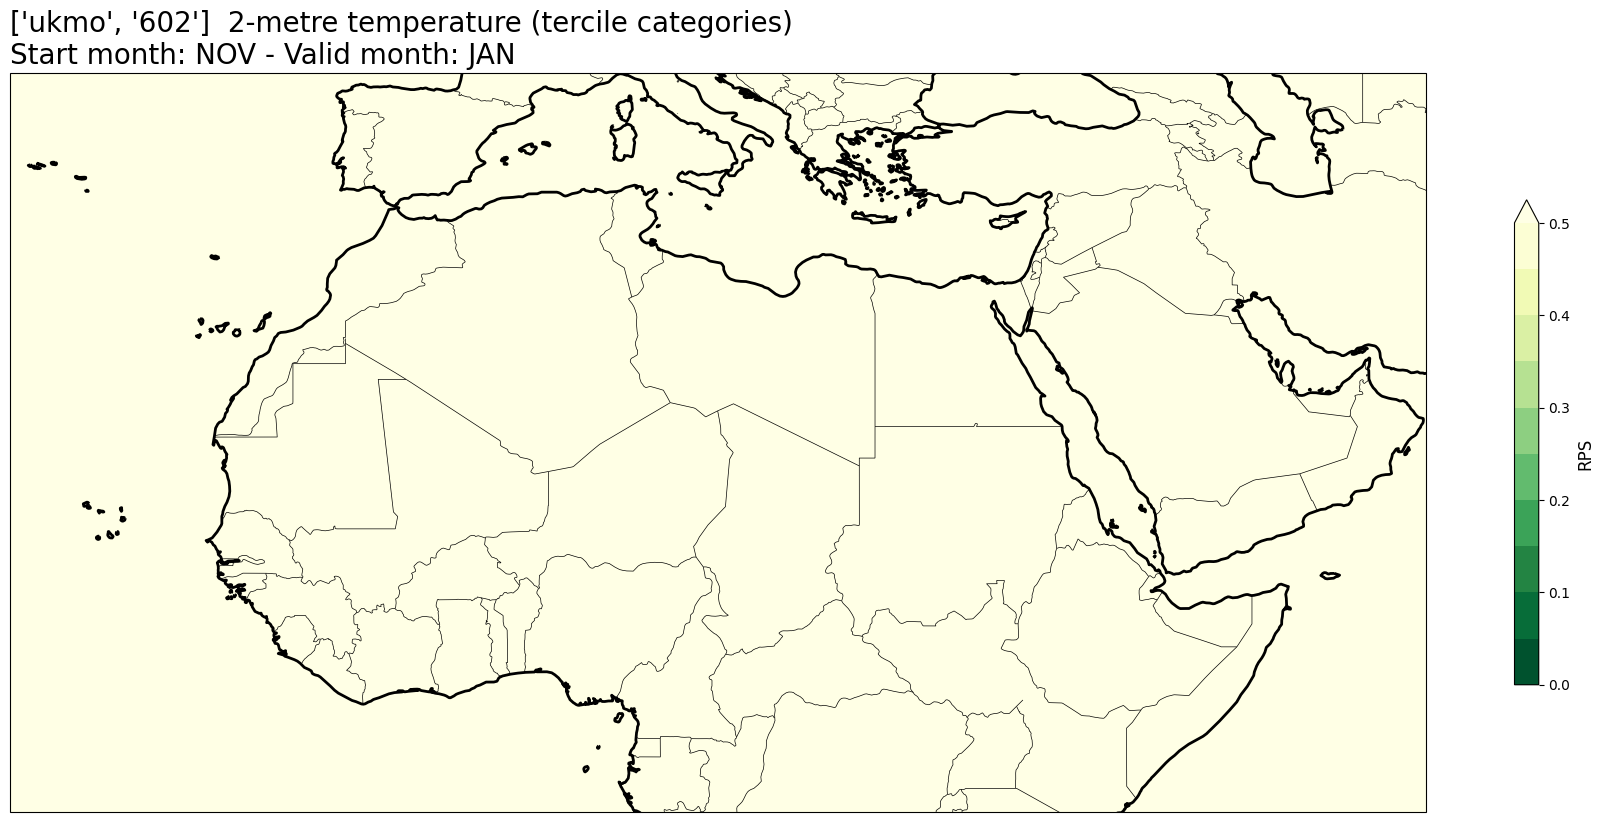

In [241]:
# READ scores xr.Datasets
rps = xr.open_dataset(f'{SCOREDIR}/{hcst_bname}.{aggr}.rps.nc')
# RE-ARRANGE the DATASETS longitude values for plotting purposes
# rps = rps.assign_coords(lon=(((rps.lon + 180) % 360) - 180)).sortby('lon')
thisrps = rps.sel(forecastMonth=fcmonth)

for var in thisrps.data_vars:
    fig = plt.figure(figsize=(18,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.)
    avalues = thisrps[var].values
    cs = plt.contourf(thisrps[var].lon,thisrps[var].lat,avalues,levels=np.linspace(0.,0.5,11),cmap='YlGn_r', extend='max')
    cs.cmap.set_under('purple')
    cb = plt.colorbar(shrink=0.5)
    cb.ax.set_ylabel('RPS',fontsize=12)
    plt.title(tit_line1 + f' {VARNAMES[var]}' + ' (tercile categories)\n' + tit_line2,loc='left')
    plt.tight_layout()  
    figname = f'{PLOTSDIR}/{hcst_bname}.{aggr}.fcmonth{fcmonth}.{var}.rps.png'
    plt.savefig(figname)  

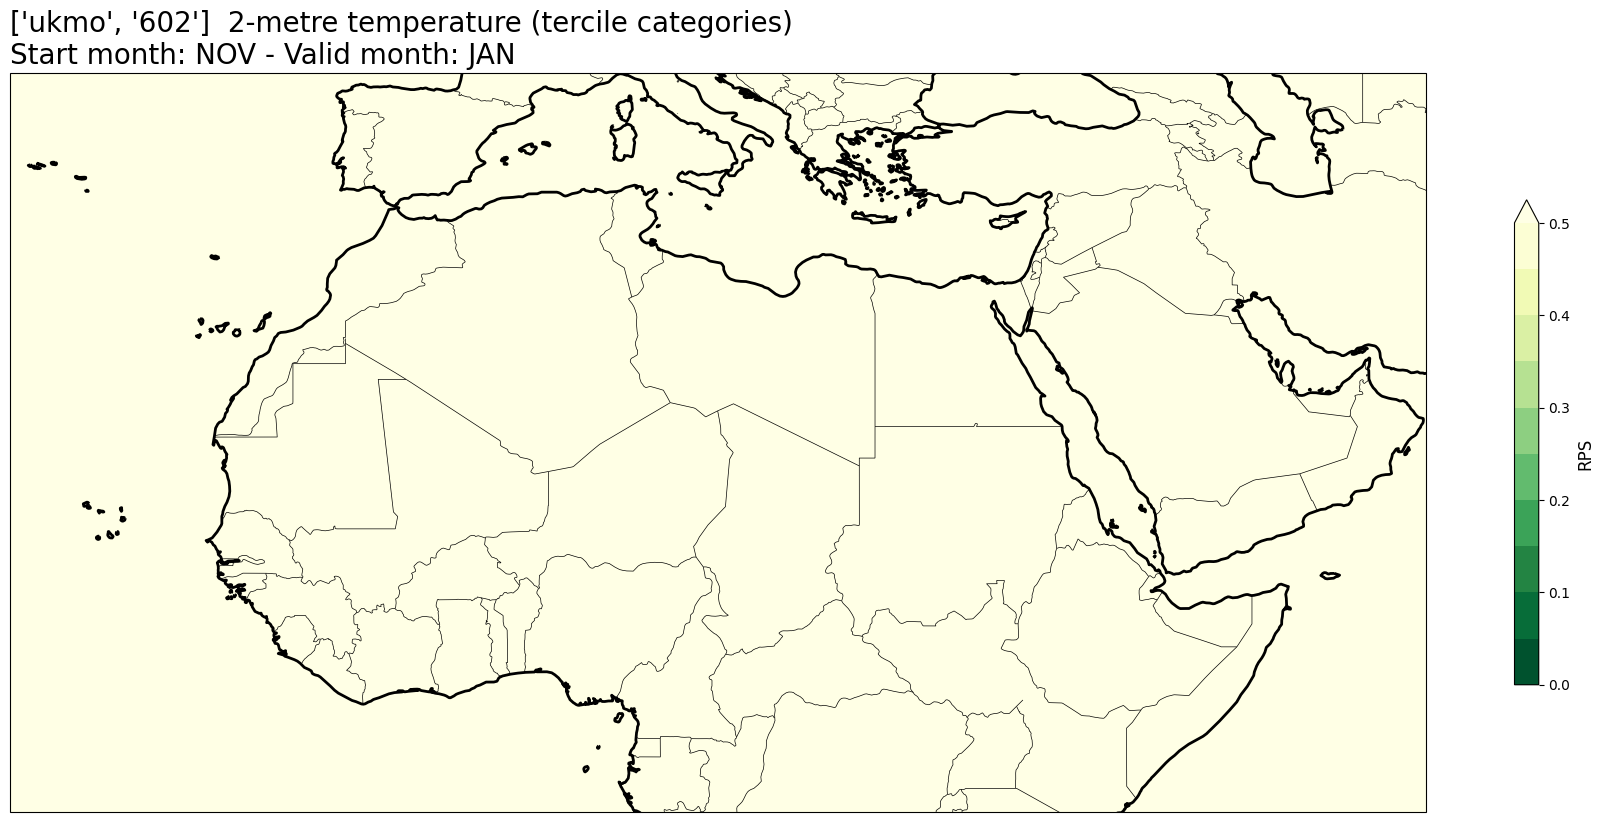

In [242]:
import calendar
import ipywidgets as widgets

# Load the datasets
def load_data(aggr):
    rps = xr.open_dataset(f'{SCOREDIR}/{hcst_bname}.{aggr}.rps.nc')
    return rps

# Define the plot function
def plot_corr(aggr, fcmonth):
    rps = load_data(aggr)
    # Prepare title line 2 based on aggregation
    tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'
    if aggr == '1m':
        validmonth = config['start_month'] + (fcmonth - 1)
        validmonth = validmonth if validmonth <= 12 else validmonth - 12
        tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'
    elif aggr == '3m':
        validmonths = [calendar.month_abbr[(config['start_month'] + (fcmonth - 1) - shift) % 12] for shift in range(3)]
        tit_line2 = tit_line2_base + f' - Valid months: {" ".join(reversed(validmonths))}'
    else:
        raise ValueError(f'Unexpected aggregation {aggr}')

    # Select data for the chosen forecast month
    thisrps = rps.sel(forecastMonth=fcmonth)
    for var in thisrps.data_vars:
        fig = plt.figure(figsize=(18,10))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.)
        avalues = thisrps[var].values
        cs = plt.contourf(thisrps[var].lon,thisrps[var].lat,avalues,levels=np.linspace(0.,0.5,11),cmap='YlGn_r', extend='max')
        cs.cmap.set_under('purple')
        cb = plt.colorbar(shrink=0.5)
        cb.ax.set_ylabel('RPS',fontsize=12)
        plt.title(tit_line1 + f' {VARNAMES[var]}' + ' (tercile categories)\n' + tit_line2,loc='left')
        plt.tight_layout()  
        plt.show()


# Create interactive widgets for `aggr` and `fcmonth`
aggr_dropdown = widgets.Dropdown(options=['1m', '3m'], value='1m', description='Aggregation:')
fcmonth_slider = widgets.IntSlider(value=3, min=2, max=4, step=1, description='Forecast Month:')
# Display the interactive plot with a single call
# out = widgets.interactive_output(plot_corr, {'aggr': aggr_dropdown, 'fcmonth': fcmonth_slider})
# display(aggr_dropdown, fcmonth_slider, out)
widgets.interactive(plot_corr, aggr=aggr_dropdown, fcmonth=fcmonth_slider)

## *4c. Area under Relative Operating Characteristic (ROC) curve*

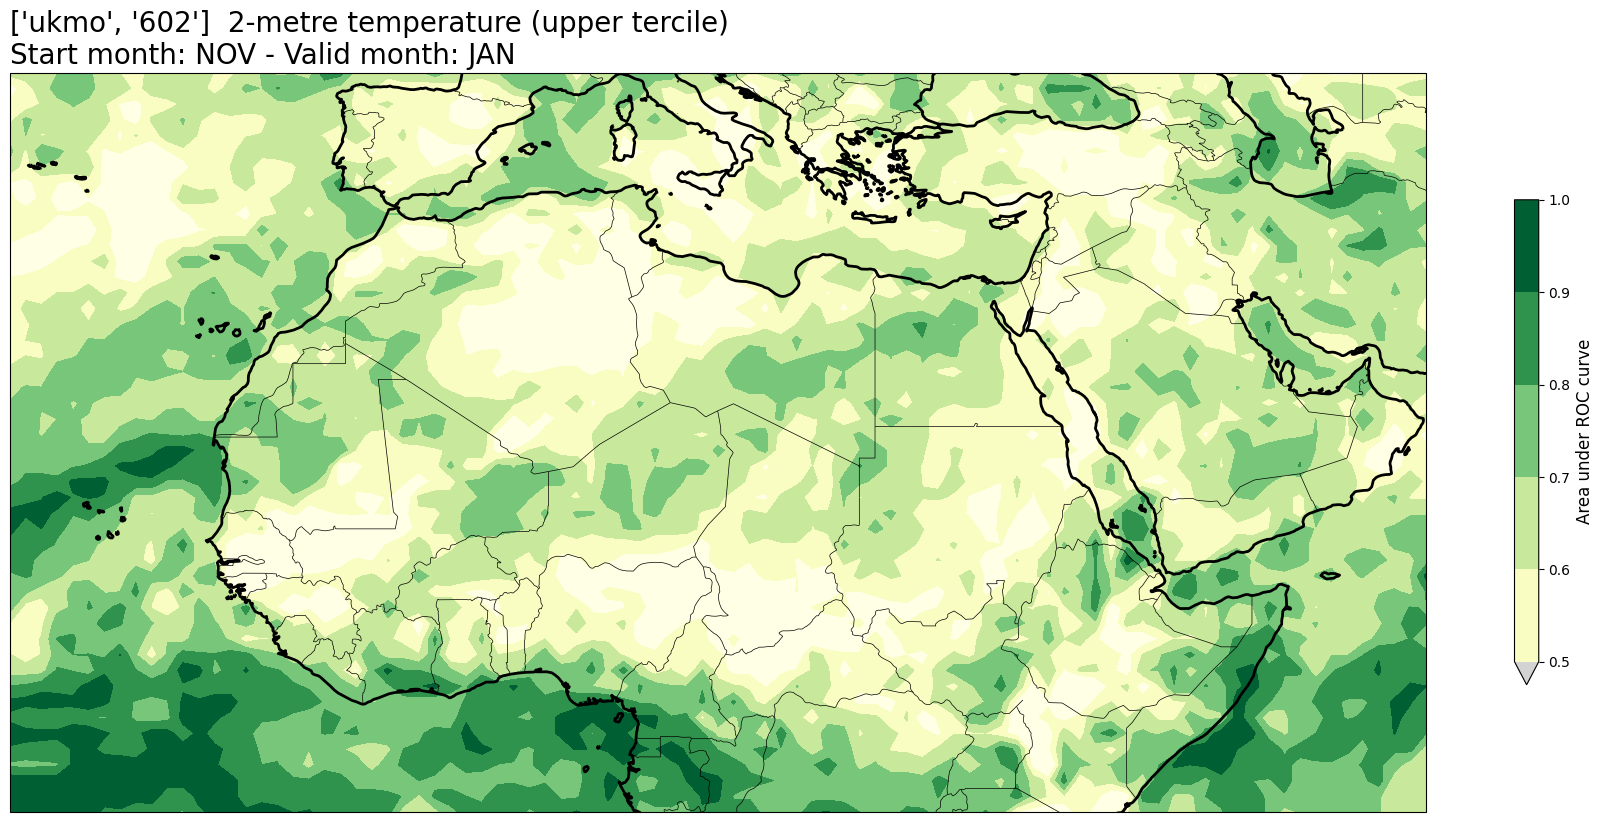

In [243]:
# READ scores xr.Datasets
def plot_roc(aggr,fcmonth,cat):
    roc = xr.open_dataset(f'{SCOREDIR}/{hcst_bname}.{aggr}.roc.nc')
    thisroc = roc.sel(forecastMonth=fcmonth)
    
    for var in thisroc.data_vars:
        fig = plt.figure(figsize=(18,10))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.)
        avalues = thisroc.sel(category=icat)[var].values
        cs = plt.contourf(thisroc[var].lon,thisroc[var].lat,avalues,levels=np.linspace(0.5,1.,6),cmap='YlGn', extend='min')
        cs.cmap.set_under('lightgray')
        cb = plt.colorbar(shrink=0.5)
        cb.ax.set_ylabel('Area under ROC curve',fontsize=12)
        plt.title(tit_line1 + f' {VARNAMES[var]}' + f' ({CATNAMES[icat]})\n' + tit_line2, loc='left')
        plt.tight_layout()  
        plt.show()
cat_slider=widgets.IntSlider(value=3,min=0,max=2,step=1,description="cat")
fcmonth_slider=widgets.IntSlider(value=3,min=2,max=4,step=1,description="fcmonth")
aggr_droptown=widgets.Dropdown(options=["1m","3m"],value="1m",description="aggr")
widgets.interactive(plot_roc,aggr=aggr_droptown,fcmonth=fcmonth_slider,cat=cat_slider)

In [1]:
# !zip -r scores.zip /kaggle/working/SF/scores


  adding: kaggle/working/SF/scores/ (stored 0%)
  adding: kaggle/working/SF/scores/cmcc_35_1993-2016_monthly_mean_11_234_45_-30_-2.5_60.1m.rocss.nc (deflated 77%)
  adding: kaggle/working/SF/scores/dwd_21_1993-2016_monthly_mean_11_234_45_-30_-2.5_60.1m.roc.nc (deflated 77%)
  adding: kaggle/working/SF/scores/ukmo_602_1993-2016_monthly_mean_11_234_45_-30_-2.5_60.1m.rps.nc (deflated 60%)
  adding: kaggle/working/SF/scores/ecmwf_51_1993-2016_monthly_mean_11_234_45_-30_-2.5_60.3m.anom.nc (deflated 64%)
  adding: kaggle/working/SF/scores/eccc_2_1993-2016_monthly_mean_11_234_45_-30_-2.5_60.1m.rps.nc (deflated 67%)
  adding: kaggle/working/SF/scores/ukmo_602_1993-2016_monthly_mean_11_234_45_-30_-2.5_60.3m.roc.nc (deflated 88%)
  adding: kaggle/working/SF/scores/meteo_france_8_1993-2016_monthly_mean_11_234_45_-30_-2.5_60.1m.roc.nc (deflated 77%)
  adding: kaggle/working/SF/scores/ecmwf_51_1993-2016_monthly_mean_11_234_45_-30_-2.5_60.1m.rocss.nc (deflated 77%)
  adding: kaggle/working/SF/scores